In [1]:
import numpy as np
import h5py
import os
import cv2


In [13]:
def get_event_from_file(path):
    data = np.load(path)
    data = np.array([data['x'],data['y'],data['p'],data['t']]).astype(int)

#normalizing time
    data[3][:] -= data[3][0]
    return data
k= 5


In [14]:

def gauss_decoder(y_array,sigma,max):
    a = (y_array-1)/254 #np.maximum((y_array-1)/254,0)
    # Replace negative values with -1
    a = np.where(a < 0, -1, a)
    b = 2*(sigma**2)
    c = np.where(a > 0, np.log(a),0)
    #print(np.where(np.isnan(c)))
    d = np.sqrt(-c*b)
    
    return (max-d)

#res = gauss_decoder(a_subset,(decode_param[0]/k),decode_param[0])


In [15]:
def gaus_decaying(x, max, k = 5):
    sigma = max/k
    return 1+254 * np.exp(-((x - max) ** 2) / (2 * sigma ** 2))



def offline_tencode(events,deltat=10e3,k=10,compute_error=False):



    t_data = events[3,:]
    t_max  = t_data.max()

    
    
    num_bins = int(t_max//deltat) + (t_max % deltat > 0) #this gets lower than the final, should clamp with tmax
    representation = np.zeros([events[1].max(),events[0].max(),2,num_bins]) #initialization

    if compute_error:
        error_representation = np.zeros([events[1].max(),events[0].max(),2,num_bins])
    else:
        error_representation = []
    
    bin_max = np.zeros([num_bins])
    
    delta_base = deltat/2

    for bin in range(num_bins):

        t_base = delta_base + deltat*bin
        t_localmin = t_base - delta_base
        t_localmax = min(t_base + delta_base, t_max)
        

        #Slicing per iteration of t_base
        filtered_indices = (events[3, :] >= t_localmin) & (events[3, :] <= t_localmax)
        filtered_events = events[:,filtered_indices]

        #Computing vectorized value
        
        t_normalized = gaus_decaying(filtered_events[3,:],t_localmax,k)
        
        bin_max[bin] = t_localmax
        
        for j in range(len(filtered_events[1])):
            
            
            
            #Checking polarity of event to put in first or second channel

            if filtered_events[2,j] == 1:
            
                representation[filtered_events[1,j]-1,filtered_events[0,j]-1,0,bin] = t_normalized[j]
                if compute_error:

                    error_representation[filtered_events[1,j]-1,filtered_events[0,j]-1,0,bin] = filtered_events[3,j] - gauss_decoder(t_normalized[j],t_localmax/k,t_localmax)
                    
            else:
                representation[filtered_events[1,j]-1,filtered_events[0,j]-1,1,bin] = t_normalized[j]
                if compute_error:

                    error_representation[filtered_events[1,j]-1,filtered_events[0,j]-1,1,bin] = filtered_events[3,j] - gauss_decoder(t_normalized[j],t_localmax/k,t_localmax)
                   
    return representation, error_representation

data = get_event_from_file('/home/camilo/juantorch/dataset/Slice/2024_04_11_17_31_47/warped_events/00000.npz')
a, decode_param = offline_tencode(data,10e3,k,True)



In [16]:
print("Memory size of numpy array in bytes:",
      (a.size * a.itemsize)/1000000)
print("Memory size of numpy array in bytes:",
      (data.size * data.itemsize)/1000000)


Memory size of numpy array in bytes: 142.758
Memory size of numpy array in bytes: 22.39792


In [11]:
#data = get_event_from_file('/home/camilo/juantorch/dataset/Slice/2024_04_12_11_53_11/warped_events/00000.npz')
#a, decode_param = offline_tencode(data,10e3,k,True)



Just visualization stuff below this.

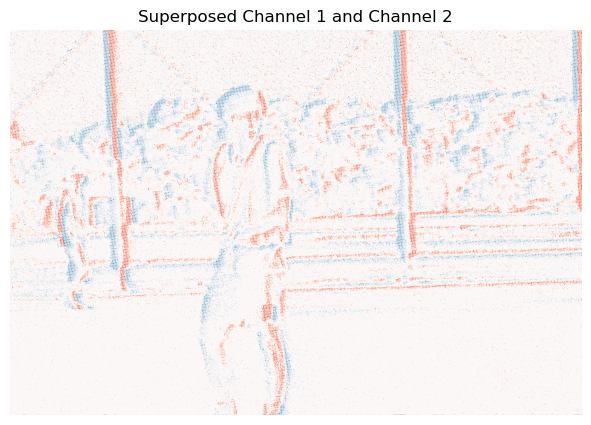

In [17]:
import matplotlib.pyplot as plt


H, W = 927, 1375

# Plot the two channels side by side
plt.figure(figsize=(10, 5))

# Display the first channel with 'Reds' colormap
plt.imshow(a[:,:,0,5], cmap='Reds', vmin=0, vmax=255)

# Overlay the second channel with 'Blues' colormap, using alpha for transparency
plt.imshow(a[:,:,1,5], cmap='Blues', vmin=0, vmax=255, alpha=0.5)

# Set the title and remove axes
plt.title("Superposed Channel 1 and Channel 2")
plt.axis("off")

# Show the plot
plt.show()




In [7]:
b =  a[:,:,1,5] - a[:,:,1,0]  


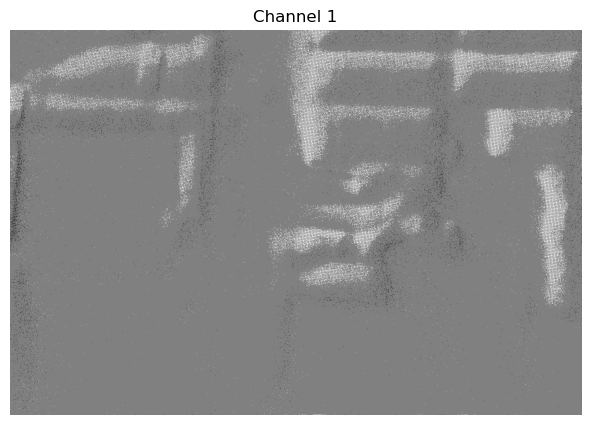

In [8]:
plt.figure(figsize=(10, 5))  

plt.imshow(b, cmap='gray', vmin=-255, vmax=255)  
plt.title("Channel 1")
plt.axis("off")  

plt.show()


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Just doing video
directory = '/home/camilo/juantorch/dataset/Slice/2024_04_11_17_31_47/warped_events/'

#
output_size = (1375, 927)  
fps = 18
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('event_video.mp4', fourcc, fps, output_size)
try:
    
    files = [f for f in os.listdir(directory) if f.endswith('.npz')]
    files.sort(key=lambda x: int(x.split('.')[0]))  # Sort based on the numerical value
    
    for file_name in files:
            file_path = os.path.join(directory, file_name)
            print(f"Processing event stream: {file_name}")
        
            # Get the event stream from the .npz file
            event_stream = get_event_from_file(file_path)
            
            # Convert the event stream into the intensity array
            intensity_map,wht = offline_tencode(event_stream)
            
            # Iterate over the time bins (dimension 3)
            for t in range(intensity_map.shape[3]):
                # Create the figure with a specific size that matches your desired output
                fig = plt.figure(figsize=(13.75, 9.27))  # Size in inches
                ax = fig.add_subplot(111)
                
                # Display the first channel (reds)
                ax.imshow(intensity_map[:,:,0,t], cmap='Reds', vmin=0, vmax=255)
                
                # Overlay the second channel (blues)
                ax.imshow(intensity_map[:,:,1,t], cmap='Blues', vmin=0, vmax=255, alpha=0.5)
                
                # Set the title and remove axes
                ax.set_title(f"Superposed Channel 1 and Channel 2 (File: {file_name}, Time bin {t})")
                ax.axis("off")
                
                # Ensure tight layout
                plt.tight_layout()
                
                # Create a canvas and render the figure
                canvas = FigureCanvas(fig)
                canvas.draw()
                
                # Get the width and height of the figure in pixels
                width, height = fig.get_size_inches() * fig.get_dpi()
                width, height = int(width), int(height)
                
                # Convert canvas to image
                image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
                image = image.reshape(height, width, 3)
                
                # Resize to match the video dimensions
                image = cv2.resize(image, output_size)
                
                # Convert RGB to BGR
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                
                # Write the frame
                video.write(image)
                
                # Close the figure
                plt.close(fig)

finally:
    # Release the video writer
    video.release()
    plt.close('all')
    print("Video generation complete!")


Processing event stream: 00000.npz


/tmp/ipykernel_7864/2959890712.py:58: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


Processing event stream: 00001.npz
Processing event stream: 00002.npz
Processing event stream: 00003.npz
Processing event stream: 00004.npz
Processing event stream: 00005.npz
Processing event stream: 00006.npz
Processing event stream: 00007.npz
Processing event stream: 00008.npz
Processing event stream: 00009.npz
Processing event stream: 00010.npz
Processing event stream: 00011.npz
Processing event stream: 00012.npz
Processing event stream: 00013.npz
Processing event stream: 00014.npz
Processing event stream: 00015.npz
Processing event stream: 00016.npz
Processing event stream: 00017.npz
Processing event stream: 00018.npz
Processing event stream: 00019.npz
Processing event stream: 00020.npz
Processing event stream: 00021.npz
Processing event stream: 00022.npz
Processing event stream: 00023.npz
Processing event stream: 00024.npz
Processing event stream: 00025.npz
Processing event stream: 00026.npz
Processing event stream: 00027.npz
Processing event stream: 00028.npz
Video generation com